In [ ]:
import jax
from jax import numpy as jnp
import json
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats 
import discovery as ds
import discovery.flow as fw
from flowjax.distributions import Normal
import flowjax
import optax 
import corner
import pandas as pd
import math
import equinox as eqx
jax.config.update('jax_enable_x64', True)

from flowjax.bijections import RationalQuadraticSpline, Affine
from flowjax.distributions import StandardNormal, Transformed
from flowjax.flows import masked_autoregressive_flow
from flowjax.train import fit_to_key_based_loss
from flowjax.train.losses import ElboLoss

import flowjax.bijections as bij

import discovery.EPTA as epta
import discovery.serialisation as serial


## Single pulsar 

Load the selected pulsar

In [2]:
names = ['J1012+5307']
d_psrs = [ds.Pulsar.read_feather('../data/EPTA_feather_new/' + f'{psrfile}') for psrfile in names]

psl_model = epta.makemodel_singlepulsar(d_psrs, psr_name = names[0])

Pulsar.read_feather: cannot find dmx in feather file discovery/EPTA_addition/EPTA_feather_new/J1012+5307.


Transform the likelihood and build the model with deafult options

In [3]:
transformed_logL = ds.makelogtransform_uniform(psl_model.logL, ds.priordict_standard)
jlogl = jax.jit(transformed_logL)

hyperparams = {'n_samples': 512, 'knots': 8, 'interval': 5, 'patience': 300, 'multibatch': 1, 'LR': 1e-3, 'steps': 2000, 'flow_lay': 8, 'deepness': 1}
flow_final = serial.make(key=jr.PRNGKey(1), loglike = psl_model, **hyperparams)

Run the Flow and save the trained model

In [ ]:
# Run the flow
out_flow = fw.VariationalFit(dist = flow_final, learning_rate=hyperparams['LR'], loss_fn = fw.ElboLoss(jlogl, num_samples=hyperparams['n_samples']), multibatch = hyperparams['multibatch'], show_progress = True, patience = hyperparams['patience'])
key, flw_params = out_flow.run(jax.random.key(1), steps = hyperparams['steps'])

# Save the parameters
serial.save("DF_MAF_" + "J1012" + ".eqx", hyperparams, flw_params)

Load the trained Flow with the default configuration and take same samples

In [7]:
flowmodel_1012 = serial.load('EPTA_example_files/DF_MAF_J1012.eqx', loglike = psl_model)
samples_1012 = flowmodel_1012.sample(jax.random.key(42), (10000,))
flow_1012 = jlogl.to_df(samples_1012)

{'n_samples': 512, 'knots': 8, 'interval': 5, 'patience': 300, 'multibatch': 1, 'LR': 0.001, 'steps': 2000, 'flow_lay': 8, 'deepness': 1}


## Enterprise Comparison

Load the chain from a single pulsar noise analysis made with enterprise and compare the posterior

In [8]:
psr_dir = 'ptmcmc_psr_J1012_EPTAPaper'
outdir = 'EPTA_examples_files' + psr_dir

chain_1012 = np.genfromtxt(f"{outdir}/chain_1.txt")
names_1012= np.loadtxt(f"{outdir}/pars.txt", dtype=str)
chain_1012 = np.delete(chain_1012,[chain_1012.shape[1]-1,chain_1012.shape[1]-2,chain_1012.shape[1]-3,chain_1012.shape[1]-4],1)
burn_1012 = int(0.25 * chain_1012.shape[0])
burned_1012 = chain_1012[burn_1012:, :]

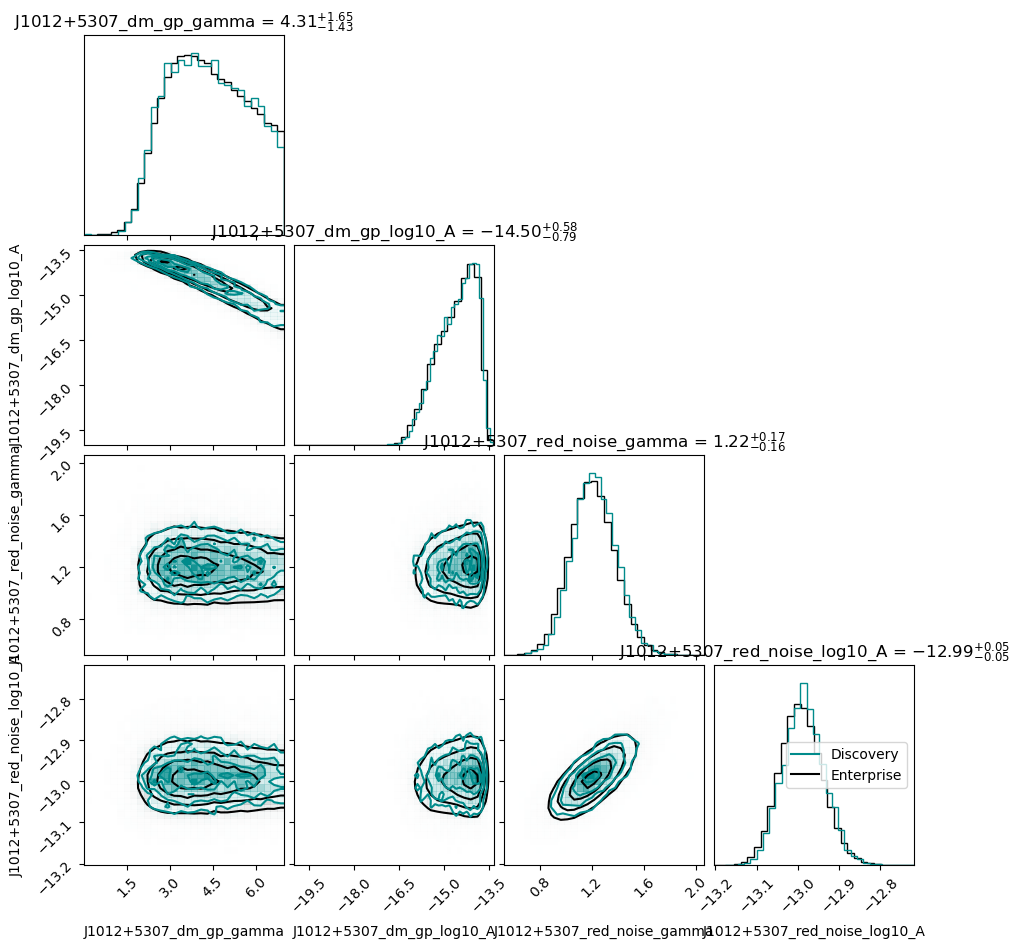

In [9]:
# corner plot
fig6 = corner.corner(burned_1012, bins = 30, show_titles=1, plot_datapoints=False, hist_kwargs={'density': True})
corner.corner(flow_1012, bins=30, color='darkcyan', show_titles=1, labels=names_1012, fig = fig6, hist_kwargs={'density': True}, plot_datapoints=False)

plt.plot([],[], c = 'darkcyan', label = 'Discovery')
plt.plot([],[], c = 'black', label = 'Enterprise')
plt.legend()
plt.show()

Compute the Hellinger distance 

In [10]:
print('J1012: ', fw.hellinger(flow_1012, burned_1012))

J1012:  0.0008524148953377164
